<a href="https://colab.research.google.com/github/NeuronsUII/Pathologies_ArtDental_n/blob/main/Kotov%20Alexander/05_Get_Tensors_from_DICOM_(%D0%B2_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Извлечение трехмерных тензоров (левого и правого сустава) из DICOM
На данном этапе, координаты и размеры тензоров определены вручную.

In [ ]:
!pip -q install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.0 MB/s eta 0:00:00


In [ ]:
# Импортируем библиотеки
import os # функции операционной системы
import requests # модуль для работы с HTTP-запросами
import time # для расчета времени выполнения операций
from urllib.parse import urlencode # импортируем функцию обработки URL
import shutil # модуль с набором функций высокого уровня для обработки файлов, групп файлов, и папок
import pydicom # для работы с DICOM-файлами
import numpy as np # Работа с numpy-массивами
from PIL import Image # Отрисовка изображений
import matplotlib.pyplot as plt # Отрисовка графиков
from matplotlib.patches import Rectangle # рисование прямоугольников
from matplotlib.animation import FuncAnimation # для создания анимационного gif

In [ ]:
# Загружаем zip-архив с DICOM исследованием с Яндекс диска в папку content
# имя архива: код пациента (например, К153.zip)
# содержимое архива: папка (имя папки - код пациента: К153), содержащая снимки в аксиальной проекции *.dcm

PATHIENT_CODE = 'К153' # код пациента (имя архива с DICOM исследованием)

filename = PATHIENT_CODE + '.zip' # имя архива

cur_time = time.time()  # Засекаем текущее время
# Получаем загрузочную ссылку
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/n8_c8CrRQo_7Gg'  # ссылка на файл (архив) на Яндекс диске
final_url = base_url + urlencode(dict(public_key=public_key))
# запрос ссылки на скачивание
response = requests.get(final_url)
download_url = response.json()['href']
# Загружаем файл и сохраняем его в папку content
download_response = requests.get(download_url)

with open(filename, 'wb') as f:
    f.write(download_response.content) # сохраняем файл в папку content на google

if os.path.exists(PATHIENT_CODE): # если папка уже существует, удалим ее со всем содержимым
    shutil.rmtree(PATHIENT_CODE)

# Распаковываем архив (zip-архив содержит папку crop_img_joint внутри которой png-файлы)
!unzip -o -q {filename}
print(f'Размер архива ({filename}):', str(round(os.path.getsize(filename) / (1024 * 1024) , 2)), 'Мб')
# Удаляем файл архива, он нам больше не нужен для работы
os.remove(filename)
# Отображаем время загрузки картинок проверочной выборки
print('Время загрузки:', round(time.time() - cur_time, 2), 'cек.', sep=' ')

Размер архива (К153.zip): 204.32 Мб
Время загрузки: 23.11 cек.


In [ ]:
# получим список файлов
dicom_file_list = os.listdir('/content/'+ PATHIENT_CODE)

# сортировка списка по алфавиту
dicom_file_list = sorted(dicom_file_list)

print('Кол-во файлов:', len(dicom_file_list))
#print(dicom_file_list)

ds = pydicom.dcmread('/content/'+ PATHIENT_CODE + '/' + dicom_file_list[0])

# Количество кадров
nr_frames = getattr(ds, "NumberOfFrames", 1)

# Извлечение метаданных:
# Полный список тегов на офсайте: https://www.dicomstandard.org/current в формате pdf (на английском)

# имя пациента
patient_name = ds.PatientName
print('Имя пациента:', patient_name)
print('ID пациента:', ds.PatientID)
print('Комментарий:', ds.PatientComments)
print('Тип медицинского оборудования:', ds.Modality)
'''
CR: Компьютерная радиография
CT: Компьютерная томография
MR: Магнитно-резонансная томография
NM: Ядерная медицина
OT: Другие типы медицинского оборудования
PT: Положитронная эмиссионная томография
US: Ультразвук
XA: Рентгеновская ангиография
'''
print('Дата проведения исследования: '+ ds.StudyDate[6:8] + '.' + ds.StudyDate[4:6] + '.' + ds.StudyDate[0:4] )
print('ID исследования:', ds.StudyInstanceUID)
#print('ID серии:', ds.SeriesInstanceUID)
#print('ID изображения:', ds.SOPInstanceUID)

print('Количество кадров (аксиальных срезов):', nr_frames)
print('Размер изображения среза (колонки, строки):', ds.Columns, 'x', ds.Rows)
print('Кол-во бит на пиксель: ', ds.BitsAllocated)
print('Размер пикселя по горизонтали и вертикали на аксиальном срезе, мм:', ds.PixelSpacing)
print('Толщина среза в трехмерном объеме данных, мм:', ds.SliceThickness)

Кол-во файлов: 600
Имя пациента: TOLSTYKH IRINA IVANOVNA
ID пациента: 40710
Комментарий: 
Тип медицинского оборудования: CT
Дата проведения исследования: 21.08.2023
ID исследования: 1.2.410.200028.479.2023821.93934
Количество кадров (аксиальных срезов): 1
Размер изображения среза (колонки, строки): 600 x 600
Кол-во бит на пиксель:  16
Размер пикселя по горизонтали и вертикали на аксиальном срезе, мм: [0.250000, 0.250000]
Толщина среза в трехмерном объеме данных, мм: 0.250


In [ ]:
# создаем 3D массив из DICOM-снимков
cur_time = time.time()  # Засекаем текущее время
dicom_in_3D_array = []
for fol_axial_slice in dicom_file_list:
    img = pydicom.read_file('/content/' + PATHIENT_CODE + '/' + fol_axial_slice).pixel_array.astype('int32')
    dicom_in_3D_array.append(img)

dicom_in_3D_array = np.array(dicom_in_3D_array)
print('Время обработки: ', round(time.time() - cur_time, 2), 'cек.', sep=' ')
print('Размерность 3D тензора DICOM:', dicom_in_3D_array.shape)

Время обработки:  1.78 cек.
Размерность 3D тензора DICOM: (600, 600, 600)


In [ ]:
# Удаляем (зануляем) пиксели, меньше заданного значения
# (запускать при необходимости)
threshold_value = 800
dicom_in_3D_array[dicom_in_3D_array < threshold_value] = 0

## **3D тензор:**
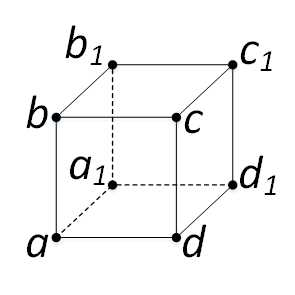

In [ ]:
# Вырезаем левый сустав в 3D-тензор
# Координаты (диапазоны границ) пока определяю визуально вручную с помощью программы IMV DICOM Viewer

# К153
# координаты вершин тензора левого сустава [Ax, Cor, Sag]:
left_a  = [240, 360, 475]
left_b  = [300, 360, 475]
left_c  = [300, 360, 570]
left_d  = [240, 360, 570]
left_a1 = [240, 440, 475]
left_b1 = [300, 440, 475]
left_c1 = [300, 440, 570]
left_d1 = [240, 440, 570]

# координаты вершин тензора правого сустава [Ax, Cor, Sag]:
right_a  = [230, 375, 100]
right_b  = [280, 375, 100]
right_c  = [280, 375, 195]
right_d  = [230, 375, 195]
right_a1 = [230, 460, 100]
right_b1 = [280, 460, 100]
right_c1 = [280, 460, 195]
right_d1 = [230, 460, 195]

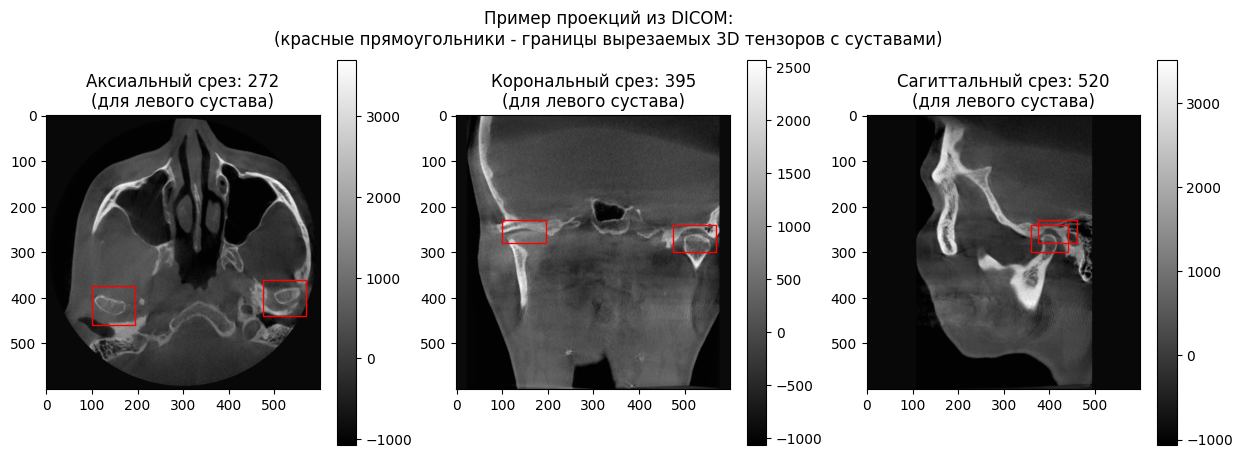

In [ ]:
# Выведем из numpy-массива проекции

axial_slice_number    = 272
coronal_slice_number  = 395
sagittal_slice_number = 520

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# аксиальный срез
axes[0].set_title(f"Аксиальный срез: {axial_slice_number}\n(для левого сустава)")
im0 = axes[0].imshow(dicom_in_3D_array[axial_slice_number,:,:], cmap='gray')
# добавление прямоугольника на аксиальном срезе (левый сустав)
rect0 = Rectangle((left_b[2], left_b[1]), abs(left_b1[2] - left_c1[2]), abs(left_b1[1] - left_b[1]), edgecolor='red', facecolor='none')
axes[0].add_patch(rect0)
# добавление прямоугольника на аксиальном срезе (правый сустав)
rect0 = Rectangle((right_b[2], right_b[1]), abs(right_b1[2] - right_c1[2]), abs(right_b1[1] - right_b[1]), edgecolor='red', facecolor='none')
axes[0].add_patch(rect0)

# корональный срез
axes[1].set_title(f"Корональный срез: {coronal_slice_number}\n(для левого сустава)")
im1 = axes[1].imshow(dicom_in_3D_array[:,coronal_slice_number,:], cmap='gray')
# добавление прямоугольника на корональном срезе (левый сустав)
rect1 = Rectangle((left_a[2], left_a[0]), abs(left_a[2]-left_d[2]), abs(left_a[0]-left_b[0]), edgecolor='red', facecolor='none')
axes[1].add_patch(rect1)
# добавление прямоугольника на корональном срезе (правый сустав)
rect1 = Rectangle((right_a[2], right_a[0]), abs(right_a[2]-right_d[2]), abs(right_a[0]-right_b[0]), edgecolor='red', facecolor='none')
axes[1].add_patch(rect1)

# сагиттальный срез
axes[2].set_title(f"Сагиттальный срез: {sagittal_slice_number}\n(для левого сустава)")
im2 = axes[2].imshow(dicom_in_3D_array[:,:,sagittal_slice_number], cmap='gray')
# добавление прямоугольника на сагиттальном срезе (левый сустав)
rect2 = Rectangle((left_a[1], left_a[0]), abs(left_a[1]-left_a1[1]), abs(left_a[0]-left_b[0]), edgecolor='red', facecolor='none')
axes[2].add_patch(rect2)
# добавление прямоугольника на сагиттальном срезе (правый сустав)
rect2 = Rectangle((right_a[1], right_a[0]), abs(right_a[1]-right_a1[1]), abs(right_a[0]-right_b[0]), edgecolor='red', facecolor='none')
axes[2].add_patch(rect2)

fig.colorbar(im0, ax=axes[0])
fig.colorbar(im1, ax=axes[1])
fig.colorbar(im2, ax=axes[2])

plt.suptitle('Пример проекций из DICOM:\n(красные прямоугольники - границы вырезаемых 3D тензоров с суставами)')
plt.show()

In [ ]:
# Создаем два 3D тензора с левым и правым суставом

# ЛЕВЫЙ ТЕНЗОР:
left_start_coords = left_a
left_tensor_size = [abs(left_b[0] - left_a[0]),
                    abs(left_b1[1] - left_b[1]),
                    abs(left_a[2] - left_d[2])
                    ]

left_tensor = dicom_in_3D_array[left_start_coords[0]:left_start_coords[0] + left_tensor_size[0],
                                left_start_coords[1]:left_start_coords[1] + left_tensor_size[1],
                                left_start_coords[2]:left_start_coords[2] + left_tensor_size[2]]
# нормирование данных (тензор левого сустава)
min_val, max_val = left_tensor.min(), left_tensor.max()
left_tensor = (left_tensor-min_val)/(max_val-min_val)
print('Размер тензора для левого сустава:', left_tensor.shape)
print('Количество элементов в тензоре:', left_tensor.size)
print('Тип данных:', type(left_tensor[0,0,0]))
print('Объем, в байтах:', np.dtype(type(left_tensor[0,0,0])).itemsize * left_tensor.size)

# ПРАВЫЙ ТЕНЗОР:
right_start_coords = right_a
right_tensor_size = [abs(right_b[0] - right_a[0]),
                    abs(right_b1[1] - right_b[1]),
                    abs(right_a[2] - right_d[2])]

right_tensor = dicom_in_3D_array[right_start_coords[0]:right_start_coords[0] + right_tensor_size[0],
                                 right_start_coords[1]:right_start_coords[1] + right_tensor_size[1],
                                 right_start_coords[2]:right_start_coords[2] + right_tensor_size[2]]
# нормирование данных (тензор правого сустава)
min_val, max_val = right_tensor.min(), right_tensor.max()
right_tensor = (right_tensor-min_val)/(max_val-min_val)
print('\nРазмер тензора для правого сустава:', right_tensor.shape)
print('Количество элементов в тензоре:', right_tensor.size)
print('Тип данных:', type(right_tensor[0,0,0]))
print('Объем, в байтах:', np.dtype(type(right_tensor[0,0,0])).itemsize * right_tensor.size)

Размер тензора для левого сустава: (60, 80, 95)
Количество элементов в тензоре: 456000
Тип данных: <class 'numpy.float64'>
Объем, в байтах: 3648000

Размер тензора для правого сустава: (50, 85, 95)
Количество элементов в тензоре: 403750
Тип данных: <class 'numpy.float64'>
Объем, в байтах: 3230000


Время создания анимации:  23.84 cек.
Размер animation.gif: 0.87 Мб


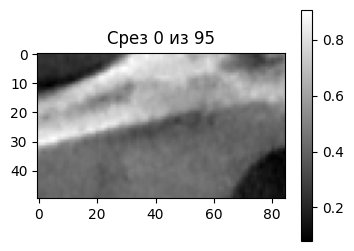

In [ ]:
# Просмотр содержимого тензора правого сустава для сагиттальной проекции в виде анимации

# Функция для создания анимации
def update(frame):
    plt.clf()  # Очистка предыдущего графика
    plt.imshow(right_tensor[:, :, frame], cmap='gray')  # Отображение среза
    plt.title(f"Срез {frame} из {right_tensor.shape[2]}")
    plt.colorbar()

cur_time = time.time() # Засекаем текущее время
# Создание анимации
fig = plt.figure(figsize=(4, 3))
ani = FuncAnimation(fig, update, frames=range(right_tensor.shape[2]), interval=100)

# Сохранение анимации в файл
ani.save('animation.gif', writer='imagemagick', fps=3)
print ('Время создания анимации: ', round(time.time() - cur_time, 2), 'cек.', sep=' ')
print('Размер animation.gif:', str(round(os.path.getsize('/content/animation.gif') / (1024 * 1024) , 2)), 'Мб')